### Load initial packages

In [2]:
from modsim import *
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import simpy as sp


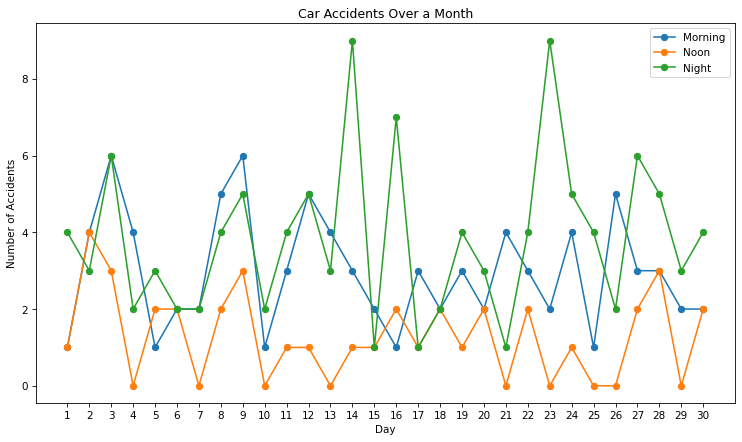

In [8]:
import simpy
import random
import pandas as pd
import matplotlib.pyplot as plt

# Adjusted simulation parameters
SIMULATION_DAYS = 30
TIME_PERIODS = ['Morning', 'Noon', 'Night']
INTERARRIVAL_TIMES = {'Morning': 3, 'Noon': 7, 'Night': 3}  # Shorter times for busier periods
ACCIDENT_PROBABILITY = 0.0027
SIMULATION_TIME = 3600  # 1 hour in seconds per period

class Intersection:
    def __init__(self, env):
        self.env = env
        self.intersection = simpy.Resource(env, capacity=1)
        self.accidents = 0  # Track accidents

    def vehicle(self, name):
        with self.intersection.request() as req:
            yield req
            yield self.env.timeout(1)
            if random.random() < ACCIDENT_PROBABILITY:
                self.accidents += 1

def vehicle_generator(env, intersection, interarrival_time):
    while True:
        yield env.timeout(random.expovariate(1.0 / interarrival_time))
        env.process(intersection.vehicle(f"Vehicle {env.now}"))

# Store simulation results
results = []

# Run simulation for each day and time period
for day in range(SIMULATION_DAYS):
    for period in TIME_PERIODS:
        env = simpy.Environment()
        intersection = Intersection(env)
        env.process(vehicle_generator(env, intersection, INTERARRIVAL_TIMES[period]))
        env.run(until=SIMULATION_TIME)
        results.append({'Day': day + 1, 'Time': period, 'Accidents': intersection.accidents})

# Convert results to DataFrame and plot
df = pd.DataFrame(results)
fig, ax = plt.subplots(figsize=(10, 6))
for period in TIME_PERIODS:
    subset = df[df['Time'] == period]
    ax.plot(subset['Day'], subset['Accidents'], marker='o', label=period)

ax.set_xlabel('Day')
ax.set_ylabel('Number of Accidents')
ax.set_title('Car Accidents Over a Month')
plt.xticks(range(1, SIMULATION_DAYS + 1))
plt.legend()
plt.tight_layout()
plt.show()